In [22]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score
from transformers import ViTConfig, ViTForImageClassification, ViTFeatureExtractor, AdamW, get_linear_schedule_with_warmup
import time

In [23]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jutepest/sample_submission.csv
/kaggle/input/jutepest/train.csv
/kaggle/input/jutepest/test.csv
/kaggle/input/jutepest/train_images/data_2198.jpg
/kaggle/input/jutepest/train_images/data_4627.jpg
/kaggle/input/jutepest/train_images/data_4335.jpg
/kaggle/input/jutepest/train_images/data_3267.jpg
/kaggle/input/jutepest/train_images/data_6807.jpg
/kaggle/input/jutepest/train_images/data_5147.jpg
/kaggle/input/jutepest/train_images/data_4768.jpg
/kaggle/input/jutepest/train_images/data_3090.jpg
/kaggle/input/jutepest/train_images/data_2961.jpg
/kaggle/input/jutepest/train_images/data_4147.jpg
/kaggle/input/jutepest/train_images/data_548.jpg
/kaggle/input/jutepest/train_images/data_2240.jpg
/kaggle/input/jutepest/train_images/data_1699.jpg
/kaggle/input/jutepest/train_images/data_2939.jpg
/kaggle/input/jutepest/train_images/data_4276.jpg
/kaggle/input/jutepest/train_images/data_2919.jpg
/kaggle/input/jutepest/train_images/data_3086.jpg
/kaggle/input/jutepest/train_images/data_

In [24]:
# Load and preview the dataset
train = pd.read_csv('/kaggle/input/jutepest/train.csv')
train.head()

,filename,class
0,data_813.jpg,Jute Stem Weevil
1,data_6274.jpg,Mealybug
2,data_2317.jpg,Black Hairy
3,data_2124.jpg,Termite
4,data_5974.jpg,Jute Aphid


In [25]:
# Encode class labels to integers
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

In [26]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])


In [27]:
# Define custom dataset class
class JutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.dataframe.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [28]:
# Create dataset and split into training and validation sets
train_dir = '/kaggle/input/jutepest/train_images/'
dataset = JutePestDataset(train, train_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

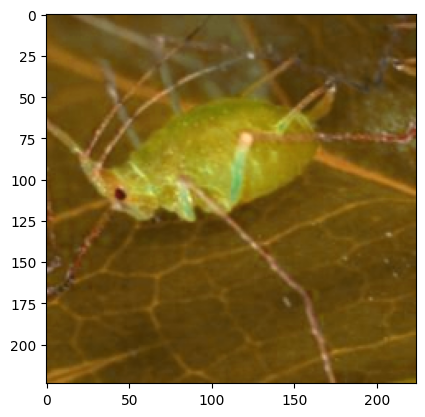

In [29]:
# Display a sample image
plt.imshow(torch.permute(dataset[4][0], (1, 2, 0)))
plt.show()

In [30]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### ViT

In [31]:
# Load ViT configuration and create a model from scratch
config = ViTConfig(num_labels=17, hidden_size=768, num_attention_heads=12, num_hidden_layers=12)
model = ViTForImageClassification(config)

In [32]:
# Define the optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [33]:
# Print model summary
from torchinfo import summary
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                                       Output Shape              Param #
ViTForImageClassification                                    [32, 17]                  --
├─ViTModel: 1-1                                              [32, 197, 768]            --
│    └─ViTEmbeddings: 2-1                                    [32, 197, 768]            152,064
│    │    └─ViTPatchEmbeddings: 3-1                          [32, 196, 768]            590,592
│    │    └─Dropout: 3-2                                     [32, 197, 768]            --
│    └─ViTEncoder: 2-2                                       [32, 197, 768]            --
│    │    └─ModuleList: 3-3                                  --                        85,054,464
│    └─LayerNorm: 2-3                                        [32, 197, 768]            1,536
├─Linear: 1-2                                                [32, 17]                  13,073
Total params: 85,811,729
Trainable params: 85,811,729
Non-trainable pa

In [34]:
# Determine the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [35]:
# Fungsi untuk menghitung akurasi
def calc_accuracy(true, pred):
    pred = F.softmax(pred, dim=1)
    acc = (true == pred.argmax(dim=1)).float().mean().item()
    return round(acc * 100, 2)

In [36]:
# Fungsi untuk menghitung F1 Score
def calc_f1_score(true, pred):
    pred = F.softmax(pred, dim=1).argmax(dim=1)
    true = true.cpu().numpy()
    pred = pred.cpu().numpy()
    return f1_score(true, pred, average='weighted')

## Melanjutkan Epoch Sebelumnya


In [37]:
checkpoint_path = ''

# Check if checkpoint exists
if os.path.exists(checkpoint_path) and checkpoint_path:
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    print(f"Checkpoint loaded, starting from epoch {start_epoch}")
else:
    # Initialize training and validation statistics
    start_epoch = 0
    best_val_loss = np.inf
    patience_counter = 0
    print("No checkpoint found, starting from scratch")

No checkpoint found, starting from scratch


## Training

In [38]:
# Initialize training and validation statistics
train_loss = []
train_accuracy = []
train_f1_score = []
val_loss = []
val_accuracy = []
val_f1_score = []
num_epochs = 100
patience = 6

In [39]:
# Determine the device to use
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [40]:
# Training loop
for epoch in range(start_epoch, num_epochs):
    start_time = time.time()
    train_epoch_loss = []
    train_epoch_accuracy = []
    train_epoch_f1_score = []
    val_epoch_loss = []
    val_epoch_accuracy = []
    val_epoch_f1_score = []

    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit='batch') as pbar:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()
            lr_scheduler.step()

            acc = calc_accuracy(labels, logits)
            f1 = calc_f1_score(labels, logits)

            train_epoch_loss.append(loss.item())
            train_epoch_accuracy.append(acc)
            train_epoch_f1_score.append(f1)

            pbar.set_postfix({'Training Loss': np.mean(train_epoch_loss), 'Training Accuracy': np.mean(train_epoch_accuracy), 'Training F1 Score': np.mean(train_epoch_f1_score)})
            pbar.update(1)

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            acc = calc_accuracy(labels, logits)
            f1 = calc_f1_score(labels, logits)

            val_epoch_loss.append(loss.item())
            val_epoch_accuracy.append(acc)
            val_epoch_f1_score.append(f1)

    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    train_epoch_f1_score = np.mean(train_epoch_f1_score)
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    val_epoch_f1_score = np.mean(val_epoch_f1_score)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1_score.append(train_epoch_f1_score)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1_score.append(val_epoch_f1_score)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.2f}%, Training F1 Score: {train_epoch_f1_score:.2f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%, Validation F1 Score: {val_epoch_f1_score:.2f}, Epoch Duration: {epoch_duration:.2f} seconds")

    # Save the model and optimizer state every 10 epochs
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
        print(f'Model saved at epoch {epoch + 1}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print('Best model saved')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    lr_scheduler.step()


Epoch 1/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=2.8, Training Accuracy=11.2, Training F1 Score=0.0512] 


Epoch 1/100, Training Loss: 2.7970, Training Accuracy: 11.18%, Training F1 Score: 0.05
Validation Loss: 2.5704, Validation Accuracy: 16.17%, Validation F1 Score: 0.11, Epoch Duration: 163.75 seconds
Best model saved


Epoch 2/100: 100%|██████████| 154/154 [02:23<00:00,  1.08batch/s, Training Loss=2.44, Training Accuracy=20.8, Training F1 Score=0.167]


Epoch 2/100, Training Loss: 2.4382, Training Accuracy: 20.75%, Training F1 Score: 0.17
Validation Loss: 2.2779, Validation Accuracy: 25.93%, Validation F1 Score: 0.21, Epoch Duration: 163.90 seconds
Best model saved


Epoch 3/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=2.23, Training Accuracy=26.8, Training F1 Score=0.234]


Epoch 3/100, Training Loss: 2.2302, Training Accuracy: 26.80%, Training F1 Score: 0.23
Validation Loss: 2.1061, Validation Accuracy: 30.22%, Validation F1 Score: 0.25, Epoch Duration: 164.08 seconds
Best model saved


Epoch 4/100: 100%|██████████| 154/154 [02:22<00:00,  1.08batch/s, Training Loss=2.04, Training Accuracy=32.8, Training F1 Score=0.299]


Epoch 4/100, Training Loss: 2.0374, Training Accuracy: 32.83%, Training F1 Score: 0.30
Validation Loss: 1.9810, Validation Accuracy: 34.99%, Validation F1 Score: 0.31, Epoch Duration: 163.25 seconds
Best model saved


Epoch 5/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=1.85, Training Accuracy=40.4, Training F1 Score=0.378]


Epoch 5/100, Training Loss: 1.8470, Training Accuracy: 40.38%, Training F1 Score: 0.38
Validation Loss: 1.7748, Validation Accuracy: 40.14%, Validation F1 Score: 0.38, Epoch Duration: 164.18 seconds
Best model saved


Epoch 6/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=1.65, Training Accuracy=46.8, Training F1 Score=0.448]


Epoch 6/100, Training Loss: 1.6470, Training Accuracy: 46.83%, Training F1 Score: 0.45
Validation Loss: 1.5682, Validation Accuracy: 48.86%, Validation F1 Score: 0.47, Epoch Duration: 165.05 seconds
Best model saved


Epoch 7/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=1.39, Training Accuracy=54.8, Training F1 Score=0.53] 


Epoch 7/100, Training Loss: 1.3867, Training Accuracy: 54.84%, Training F1 Score: 0.53
Validation Loss: 1.3199, Validation Accuracy: 56.55%, Validation F1 Score: 0.55, Epoch Duration: 164.83 seconds
Best model saved


Epoch 8/100: 100%|██████████| 154/154 [02:23<00:00,  1.08batch/s, Training Loss=1.18, Training Accuracy=62, Training F1 Score=0.608]  


Epoch 8/100, Training Loss: 1.1824, Training Accuracy: 62.05%, Training F1 Score: 0.61
Validation Loss: 1.2781, Validation Accuracy: 61.29%, Validation F1 Score: 0.60, Epoch Duration: 163.56 seconds
Best model saved


Epoch 9/100: 100%|██████████| 154/154 [02:23<00:00,  1.08batch/s, Training Loss=1.03, Training Accuracy=66.7, Training F1 Score=0.66] 


Epoch 9/100, Training Loss: 1.0268, Training Accuracy: 66.73%, Training F1 Score: 0.66
Validation Loss: 1.0105, Validation Accuracy: 68.88%, Validation F1 Score: 0.68, Epoch Duration: 163.48 seconds
Best model saved


Epoch 10/100: 100%|██████████| 154/154 [02:22<00:00,  1.08batch/s, Training Loss=0.828, Training Accuracy=73.6, Training F1 Score=0.733]


Epoch 10/100, Training Loss: 0.8276, Training Accuracy: 73.65%, Training F1 Score: 0.73
Validation Loss: 0.8712, Validation Accuracy: 72.29%, Validation F1 Score: 0.71, Epoch Duration: 163.47 seconds
Model saved at epoch 10
Best model saved


Epoch 11/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s, Training Loss=0.707, Training Accuracy=77.9, Training F1 Score=0.776]


Epoch 11/100, Training Loss: 0.7071, Training Accuracy: 77.95%, Training F1 Score: 0.78
Validation Loss: 0.7694, Validation Accuracy: 77.18%, Validation F1 Score: 0.76, Epoch Duration: 164.70 seconds
Best model saved


Epoch 12/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=0.591, Training Accuracy=81.4, Training F1 Score=0.812]


Epoch 12/100, Training Loss: 0.5915, Training Accuracy: 81.39%, Training F1 Score: 0.81
Validation Loss: 0.6411, Validation Accuracy: 80.16%, Validation F1 Score: 0.80, Epoch Duration: 164.84 seconds
Best model saved


Epoch 13/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s, Training Loss=0.511, Training Accuracy=83.8, Training F1 Score=0.838]


Epoch 13/100, Training Loss: 0.5109, Training Accuracy: 83.82%, Training F1 Score: 0.84
Validation Loss: 0.5433, Validation Accuracy: 83.99%, Validation F1 Score: 0.84, Epoch Duration: 164.80 seconds
Best model saved


Epoch 14/100: 100%|██████████| 154/154 [02:24<00:00,  1.06batch/s, Training Loss=0.416, Training Accuracy=86.9, Training F1 Score=0.868]


Epoch 14/100, Training Loss: 0.4155, Training Accuracy: 86.94%, Training F1 Score: 0.87
Validation Loss: 0.5154, Validation Accuracy: 85.85%, Validation F1 Score: 0.86, Epoch Duration: 165.12 seconds
Best model saved


Epoch 15/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=0.354, Training Accuracy=89.2, Training F1 Score=0.893]


Epoch 15/100, Training Loss: 0.3543, Training Accuracy: 89.24%, Training F1 Score: 0.89
Validation Loss: 0.4843, Validation Accuracy: 86.60%, Validation F1 Score: 0.86, Epoch Duration: 164.23 seconds
Best model saved


Epoch 16/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s, Training Loss=0.295, Training Accuracy=90.8, Training F1 Score=0.908]


Epoch 16/100, Training Loss: 0.2951, Training Accuracy: 90.81%, Training F1 Score: 0.91
Validation Loss: 0.4478, Validation Accuracy: 87.96%, Validation F1 Score: 0.88, Epoch Duration: 164.74 seconds
Best model saved


Epoch 17/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s, Training Loss=0.26, Training Accuracy=92.1, Training F1 Score=0.922] 


Epoch 17/100, Training Loss: 0.2602, Training Accuracy: 92.05%, Training F1 Score: 0.92
Validation Loss: 0.4217, Validation Accuracy: 88.76%, Validation F1 Score: 0.88, Epoch Duration: 164.90 seconds
Best model saved


Epoch 18/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=0.214, Training Accuracy=93.5, Training F1 Score=0.933]


Epoch 18/100, Training Loss: 0.2140, Training Accuracy: 93.50%, Training F1 Score: 0.93
Validation Loss: 0.3778, Validation Accuracy: 89.66%, Validation F1 Score: 0.89, Epoch Duration: 164.48 seconds
Best model saved


Epoch 19/100: 100%|██████████| 154/154 [02:23<00:00,  1.07batch/s, Training Loss=0.178, Training Accuracy=94.7, Training F1 Score=0.946]


Epoch 19/100, Training Loss: 0.1778, Training Accuracy: 94.71%, Training F1 Score: 0.95
Validation Loss: 0.3621, Validation Accuracy: 89.70%, Validation F1 Score: 0.89, Epoch Duration: 164.57 seconds
Best model saved


Epoch 20/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s, Training Loss=0.156, Training Accuracy=95.6, Training F1 Score=0.956]


Epoch 20/100, Training Loss: 0.1556, Training Accuracy: 95.58%, Training F1 Score: 0.96
Validation Loss: 0.3375, Validation Accuracy: 90.62%, Validation F1 Score: 0.91, Epoch Duration: 165.16 seconds
Model saved at epoch 20
Best model saved


Epoch 21/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s, Training Loss=0.146, Training Accuracy=96, Training F1 Score=0.96]   


Epoch 21/100, Training Loss: 0.1457, Training Accuracy: 96.04%, Training F1 Score: 0.96
Validation Loss: 0.3602, Validation Accuracy: 90.76%, Validation F1 Score: 0.91, Epoch Duration: 164.80 seconds


Epoch 22/100: 100%|██████████| 154/154 [02:24<00:00,  1.06batch/s, Training Loss=0.149, Training Accuracy=95.9, Training F1 Score=0.959]


Epoch 22/100, Training Loss: 0.1489, Training Accuracy: 95.90%, Training F1 Score: 0.96
Validation Loss: 0.3751, Validation Accuracy: 90.04%, Validation F1 Score: 0.90, Epoch Duration: 165.78 seconds


Epoch 23/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s, Training Loss=0.157, Training Accuracy=95.6, Training F1 Score=0.956]


Epoch 23/100, Training Loss: 0.1570, Training Accuracy: 95.56%, Training F1 Score: 0.96
Validation Loss: 0.3537, Validation Accuracy: 90.04%, Validation F1 Score: 0.90, Epoch Duration: 164.87 seconds


Epoch 24/100: 100%|██████████| 154/154 [02:24<00:00,  1.06batch/s, Training Loss=0.151, Training Accuracy=95.7, Training F1 Score=0.956]


Epoch 24/100, Training Loss: 0.1513, Training Accuracy: 95.66%, Training F1 Score: 0.96
Validation Loss: 0.3682, Validation Accuracy: 90.12%, Validation F1 Score: 0.90, Epoch Duration: 165.81 seconds


Epoch 25/100: 100%|██████████| 154/154 [02:24<00:00,  1.07batch/s, Training Loss=0.16, Training Accuracy=95.2, Training F1 Score=0.952] 


Epoch 25/100, Training Loss: 0.1596, Training Accuracy: 95.20%, Training F1 Score: 0.95
Validation Loss: 0.3498, Validation Accuracy: 89.72%, Validation F1 Score: 0.89, Epoch Duration: 165.05 seconds


Epoch 26/100: 100%|██████████| 154/154 [02:24<00:00,  1.06batch/s, Training Loss=0.152, Training Accuracy=95.5, Training F1 Score=0.955]


Epoch 26/100, Training Loss: 0.1515, Training Accuracy: 95.54%, Training F1 Score: 0.95
Validation Loss: 0.3709, Validation Accuracy: 89.94%, Validation F1 Score: 0.90, Epoch Duration: 165.07 seconds
Early stopping triggered


In [41]:
# Save the checkpoint at the last epoch if not already saved
if (epoch + 1) % 10 != 0 and (epoch + 1) != num_epochs:
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    print(f'Model saved at the final epoch {epoch + 1}')

Model saved at the final epoch 26


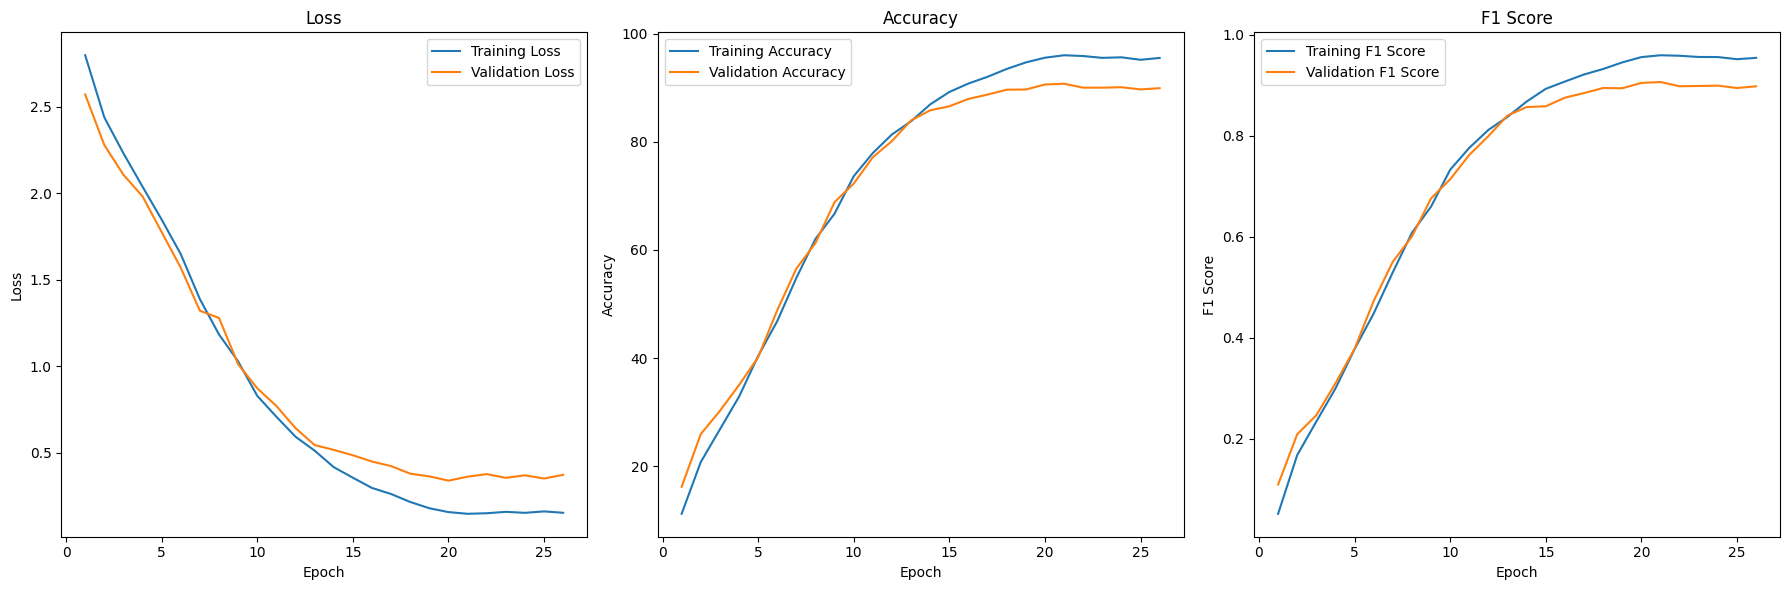

In [42]:
# Plotting the loss, accuracy, and F1 score
actual_epochs = len(train_loss)

epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(18, 6))

# Plot training & validation loss values
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation F1 score values
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_score, label='Training F1 Score')
plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [48]:
# Define the test dataset class
class TestJutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

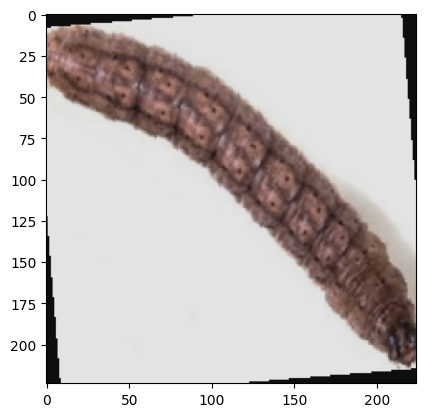

In [49]:
# Load and prepare test dataset
test_dir = '/kaggle/input/jutepest/test_images/'
test_csv = pd.read_csv('/kaggle/input/jutepest/test.csv')
test_dataset = TestJutePestDataset(test_csv, test_dir, transform)
plt.imshow(torch.permute(test_dataset[0], (1, 2, 0)))
plt.show()


In [50]:
# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [51]:
# Function for making predictions
def predict(model, test_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            logits = outputs.logits
            _, predicted = torch.max(logits, 1)
            predictions.extend(predicted.cpu().numpy())
    
    return predictions


In [52]:
# Make predictions on test dataset
predictions = predict(model, test_loader)
predicted_labels = label_encoder.inverse_transform(predictions)

In [54]:
# Prepare submission file
test = pd.read_csv('/kaggle/input/jutepest/test.csv')
sub = pd.concat([test.id, pd.DataFrame(predicted_labels, columns=['class'])], axis=1)
sub.set_index('id', inplace=True)
sub.to_csv("submission_vit.csv")
sub

,class
id,
0,Cutworm
1,Jute Hairy
2,Black Hairy
3,Field Cricket
4,Black Hairy
...,...
1081,Termite
1082,Yellow Mite
1083,Jute Stem Girdler
